## 回归树

In [146]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.datasets import load_boston
import pandas as pd
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

#### 1.数据读入并分析

In [2]:
boston = load_boston()

In [3]:
colums = list(boston.feature_names)
colums.append("COST")

In [4]:
df = pd.concat([pd.DataFrame(boston.data), pd.DataFrame(boston.target)], axis=1)

In [10]:
df.columns = colums
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,COST
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [6]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,COST
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
COST       506 non-null float64
dtypes: float64(14)
memory usage: 55.4 KB


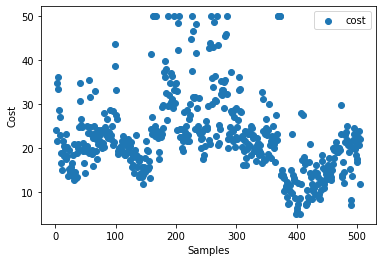

In [14]:
plt.scatter(range(1, 507), df.COST, label = "cost")
plt.xlabel("Samples")
plt.ylabel("Cost")
plt.legend()
plt.show()

In [9]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,COST
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#### 2.构建回归树
    此时构建的CART回归树的属性具有连续性性质，所以采取了连续属性离散化，即采用二分法对连续属性进行划分，已经划分的属性仍然继续可以在接下来的划分中继续进行划分。

In [54]:
## 数据处理
X_train, X_test, Y_train, Y_test = train_test_split(boston.data, boston.target, test_size = 0.3)
feature_name = list(boston.target)

In [55]:
X_train.shape, X_test.shape

((354, 13), (152, 13))

In [131]:
## 回归树
regress = tree.DecisionTreeRegressor(random_state=10
                                     ,max_depth = 9
                                     ,min_samples_split = 4
                                    )

In [132]:
regress.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=10, splitter='best')

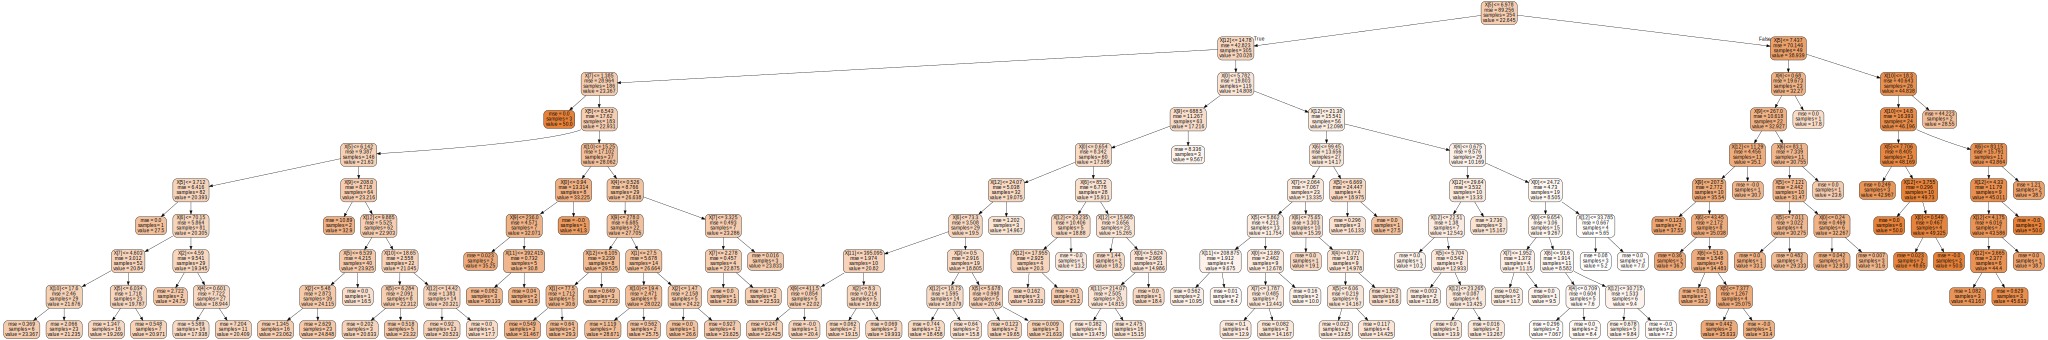

In [137]:
data_dot = tree.export_graphviz(regress
                                ,feature_names=None
                                ,filled=True
                                ,rounded = True
                               )
graph = graphviz.Source(data_dot)
graph

In [138]:
regress.score(X_train, Y_train)

0.9810785487178921

In [139]:
regress.score(X_test, Y_test)

0.7339263006774879

In [140]:
test_pred = regress.predict(X_test)

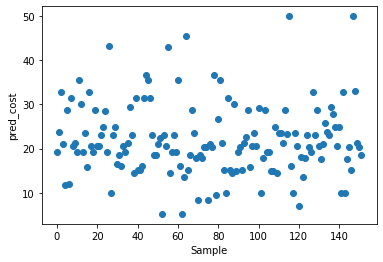

In [141]:
plt.scatter(range(0, len(test_pred)), test_pred)
plt.ylabel("pred_cost")
plt.xlabel("Sample")
plt.show()

#### 3.回归树的剪枝

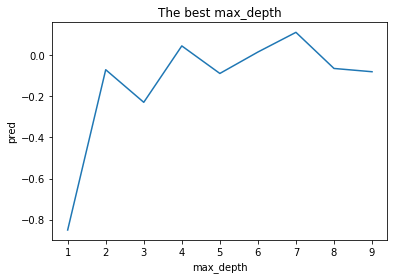

In [149]:
# 探寻更好的剪枝深度
test = []
for i in range(1, 10):
    ## 回归树
    regress = tree.DecisionTreeRegressor(random_state=10
                                         ,max_depth = i
                                         ,min_samples_split = 4
                                        )
    regress.fit(X_train, Y_train)
    score = cross_val_score(regress, boston.data, boston.target, cv=10)

    
    test.append(score.mean())
    
plt.plot(range(1, len(test)+1), test)
plt.title('The best max_depth')
plt.ylabel("pred")
plt.xlabel("max_depth")
plt.show()   

array([ 0.59424336,  0.66651037, -1.62869627,  0.34793854,  0.73073401,
        0.50510243,  0.26502228,  0.38076139, -2.13124264, -0.53520377])

#### 4.自定义数据集的测试

In [184]:
# 生成数据
rng = np.random.RandomState(0)
x = 5 * rng.rand(80, 1)
x = np.sort(x, axis=0)
x[1:5,:]

array([[0.10109199],
       [0.19593896],
       [0.30112736],
       [0.35518029]])

In [171]:
# 标签处理
y = np.sin(x).ravel()
y

array([ 0.09381086,  0.10091989,  0.19468762,  0.29659703,  0.34775941,
        0.4219966 ,  0.46221556,  0.46665628,  0.48837278,  0.52428539,
        0.55750066,  0.55938079,  0.56545335,  0.60090392,  0.63724242,
        0.65695022,  0.7137571 ,  0.72190243,  0.83211579,  0.86461509,
        0.86837339,  0.93982849,  0.95404544,  0.96940081,  0.98773806,
        0.99594416,  0.99997987,  0.97440371,  0.96946478,  0.96301232,
        0.94059723,  0.87637482,  0.8538402 ,  0.81714055,  0.81553704,
        0.81259166,  0.75839099,  0.74075654,  0.72431392,  0.71619623,
        0.50756044,  0.47689441,  0.40518094,  0.38713765,  0.29682859,
        0.29496884,  0.28653555,  0.12742837,  0.1170958 ,  0.08102512,
        0.05689193,  0.05338977, -0.05797992, -0.08776485, -0.12363184,
       -0.13959787, -0.19105902, -0.21002125, -0.26432971, -0.33966747,
       -0.42082464, -0.52670976, -0.66655347, -0.68104667, -0.68968448,
       -0.72911815, -0.75404581, -0.82112167, -0.85289554, -0.86

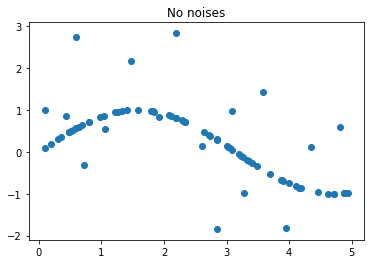

In [203]:
# 绘制无噪声数据散点图
plt.scatter(x, y)
plt.title("No noises")
plt.show()

In [181]:
# 添加噪声　模拟真是数据分布情况
y[::5] += 5*(0.5 - rng.rand(16)) 

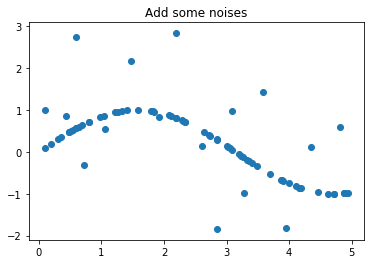

In [202]:
# 绘制噪声数据散点图，增加数据随机性
plt.scatter(x, y)
plt.title("Add some noises")
plt.show()

In [185]:
# 做数据回归预测
reg1 = tree.DecisionTreeRegressor(max_depth=2)
reg2 = tree.DecisionTreeRegressor(max_depth=5)
reg1.fit(x, y)
reg2.fit(x, y)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [188]:
#寻找测试机
X_test = np.arange(0.0, 5.0, 0.01)
X_test.shape

(500,)

In [191]:
X_test = X_test.reshape(500, 1)

In [193]:
pred1 = reg1.predict(X_test)
pred2 = reg2.predict(X_test)

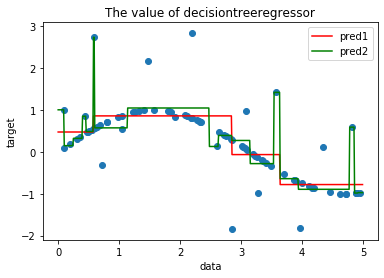

In [206]:
plt.scatter(x, y)
plt.plot(X_test, pred1, label="pred1", color="r")
plt.plot(X_test, pred2, label="pred2", color='g')
plt.title("The value of decisiontreeregressor")
plt.xlabel("data")
plt.ylabel("target")
plt.legend()
plt.show()